In [12]:
# Importing the necessary libraries

import tensorflow as tf
import albumentations as albu
import numpy as np
import gc
import pickle
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import BCDUnet
from ImageLoader import ImageLoader2D

In [13]:
# Checking the number of GPUs available

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [14]:
# Setting the model parameters

img_size = 352
dataset_type = 'kvasir' # Options: kvasir/cvc-clinicdb/cvc-colondb/etis-laribpolypdb
learning_rate = 1e-4
seed_value = 58800
filters = 17 # Number of filters, the paper presents the results with 17 and 34
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

current_datetime = datetime.datetime.now()
ct = "_".join([str(current_datetime.year), str(current_datetime.month), str(current_datetime.day), str(current_datetime.hour), str(current_datetime.minute), str(current_datetime.second)])

model_type = "BCDUnet"

progress_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) +  '_' + str(ct) + '.csv'
progressfull_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.txt'
plot_path = 'ProgressFull/' + model_type + '_filters_' + str(filters) + '_' + str(ct) + '.png'
model_path = 'ModelSaveTensorFlow/' + model_type + '_filters_' + str(filters) + '_' + str(ct)

EPOCHS = 600
min_loss_for_saving = 0.9

In [15]:
# Loading the data

X, Y = ImageLoader2D.load_data(img_size, img_size, -1, 'kvasir')

Resizing training images and masks: 40


40it [00:05,  7.24it/s]


In [16]:
# Splitting the data, seed for reproducibility

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle= True, random_state = seed_value)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.111, shuffle= True, random_state = seed_value)

In [17]:
# Defining the augmentations

aug_train = albu.Compose([
    albu.HorizontalFlip(),
    albu.VerticalFlip(),
    albu.ColorJitter(brightness=(0.6,1.6), contrast=0.2, saturation=0.1, hue=0.01, always_apply=True),
    albu.Affine(scale=(0.5,1.5), translate_percent=(-0.125,0.125), rotate=(-180,180), shear=(-22.5,22), always_apply=True),
])

def augment_images():
    x_train_out = []
    y_train_out = []

    for i in range (len(x_train)):
        ug = aug_train(image=x_train[i], mask=y_train[i])
        x_train_out.append(ug['image'])  
        y_train_out.append(ug['mask'])

    return np.array(x_train_out), np.array(y_train_out)

In [18]:
# Creating the model

model = BCDUnet.create_model(img_height=img_size, img_width=img_size, input_channels=3, out_classes=1, starting_filters=filters)

In [19]:
# Compiling the model

model.compile(optimizer=optimizer, loss=dice_metric_loss)

In [20]:
# Training the model

step = 0

for epoch in range(0, EPOCHS):
    
    print(f'Training, epoch {epoch}')
    print('Learning Rate: ' + str(learning_rate))

    step += 1
        
    image_augmented, mask_augmented = augment_images()
    
    csv_logger = CSVLogger(progress_path, append=True, separator=';')
    
    model.fit(x=image_augmented, y=mask_augmented, epochs=1, batch_size=4, validation_data=(x_valid, y_valid), verbose=1, callbacks=[csv_logger])
    
    prediction_valid = model.predict(x_valid, verbose=0)
    loss_valid = dice_metric_loss(y_valid, prediction_valid)
    
    loss_valid = loss_valid.numpy()
    print("Loss Validation: " + str(loss_valid))
        
    prediction_test = model.predict(x_test, verbose=0)
    loss_test = dice_metric_loss(y_test, prediction_test)
    loss_test = loss_test.numpy()
    print("Loss Test: " + str(loss_test))
        
    with open(progressfull_path, 'a') as f:
        f.write('epoch: ' + str(epoch) + '\nval_loss: ' + str(loss_valid) + '\ntest_loss: ' + str(loss_test) + '\n\n\n')
    
    if min_loss_for_saving > loss_valid:
        min_loss_for_saving = loss_valid
        print("Saved model with val_loss: ", loss_valid)
        model.save(model_path)
        
    del image_augmented
    del mask_augmented

    gc.collect()

Training, epoch 0
Learning Rate: 0.0001
8/8 [==============================] - 11s 355ms/step - loss: 0.8115 - val_loss: 0.8123
Loss Validation: 0.81228894
Loss Test: 0.7798632
Saved model with val_loss:  0.81228894


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 1
Learning Rate: 0.0001
8/8 [==============================] - 2s 208ms/step - loss: 0.7661 - val_loss: 0.8126
Loss Validation: 0.81259084
Loss Test: 0.78026915
Training, epoch 2
Learning Rate: 0.0001
8/8 [==============================] - 2s 196ms/step - loss: 0.7417 - val_loss: 0.8128
Loss Validation: 0.8127938
Loss Test: 0.7807007
Training, epoch 3
Learning Rate: 0.0001
8/8 [==============================] - 2s 203ms/step - loss: 0.7083 - val_loss: 0.8127
Loss Validation: 0.81268847
Loss Test: 0.7806486
Training, epoch 4
Learning Rate: 0.0001
8/8 [==============================] - 2s 202ms/step - loss: 0.6897 - val_loss: 0.8124
Loss Validation: 0.81237143
Loss Test: 0.7798078
Training, epoch 5
Learning Rate: 0.0001
8/8 [==============================] - 2s 205ms/step - loss: 0.7056 - val_loss: 0.8123
Loss Validation: 0.8123308
Loss Test: 0.7797275
Training, epoch 6
Learning Rate: 0.0001
8/8 [==============================] - 2s 198ms/step - loss: 0.6836 - val_loss: 0

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 8
Learning Rate: 0.0001
8/8 [==============================] - 2s 204ms/step - loss: 0.6636 - val_loss: 0.8114
Loss Validation: 0.8114008
Loss Test: 0.7781712
Saved model with val_loss:  0.8114008


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 9
Learning Rate: 0.0001
8/8 [==============================] - 2s 200ms/step - loss: 0.6419 - val_loss: 0.8114
Loss Validation: 0.8114347
Loss Test: 0.77823293
Training, epoch 10
Learning Rate: 0.0001
8/8 [==============================] - 2s 201ms/step - loss: 0.6127 - val_loss: 0.8127
Loss Validation: 0.81270957
Loss Test: 0.780033
Training, epoch 11
Learning Rate: 0.0001
8/8 [==============================] - 2s 197ms/step - loss: 0.6360 - val_loss: 0.8132
Loss Validation: 0.8132001
Loss Test: 0.7806895
Training, epoch 12
Learning Rate: 0.0001
8/8 [==============================] - 2s 199ms/step - loss: 0.5975 - val_loss: 0.8178
Loss Validation: 0.8178489
Loss Test: 0.7854773
Training, epoch 13
Learning Rate: 0.0001
8/8 [==============================] - 2s 194ms/step - loss: 0.6210 - val_loss: 0.7731
Loss Validation: 0.7731241
Loss Test: 0.69582236
Saved model with val_loss:  0.7731241


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 14
Learning Rate: 0.0001
8/8 [==============================] - 2s 205ms/step - loss: 0.6190 - val_loss: 0.8216
Loss Validation: 0.8215988
Loss Test: 0.79077804
Training, epoch 15
Learning Rate: 0.0001
8/8 [==============================] - 2s 199ms/step - loss: 0.5377 - val_loss: 0.8293
Loss Validation: 0.8292956
Loss Test: 0.8010368
Training, epoch 16
Learning Rate: 0.0001
8/8 [==============================] - 2s 203ms/step - loss: 0.5915 - val_loss: 0.8352
Loss Validation: 0.83524793
Loss Test: 0.8090428
Training, epoch 17
Learning Rate: 0.0001
8/8 [==============================] - 2s 197ms/step - loss: 0.5871 - val_loss: 0.8125
Loss Validation: 0.812499
Loss Test: 0.75957084
Training, epoch 18
Learning Rate: 0.0001
8/8 [==============================] - 2s 195ms/step - loss: 0.5467 - val_loss: 0.8095
Loss Validation: 0.8095091
Loss Test: 0.74968636
Training, epoch 19
Learning Rate: 0.0001
8/8 [==============================] - 2s 196ms/step - loss: 0.5532 - val_lo

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 27
Learning Rate: 0.0001
8/8 [==============================] - 2s 202ms/step - loss: 0.5346 - val_loss: 0.7900
Loss Validation: 0.78997815
Loss Test: 0.6698414
Training, epoch 28
Learning Rate: 0.0001
8/8 [==============================] - 2s 200ms/step - loss: 0.5353 - val_loss: 0.6957
Loss Validation: 0.6957314
Loss Test: 0.51093245
Training, epoch 29
Learning Rate: 0.0001
8/8 [==============================] - 2s 205ms/step - loss: 0.5074 - val_loss: 0.6648
Loss Validation: 0.6647806
Loss Test: 0.5264534
Training, epoch 30
Learning Rate: 0.0001
8/8 [==============================] - 2s 200ms/step - loss: 0.5599 - val_loss: 0.6279
Loss Validation: 0.62788945
Loss Test: 0.5170751
Saved model with val_loss:  0.62788945


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 31
Learning Rate: 0.0001
8/8 [==============================] - 2s 212ms/step - loss: 0.5466 - val_loss: 0.8092
Loss Validation: 0.80922735
Loss Test: 0.7840221
Training, epoch 32
Learning Rate: 0.0001
8/8 [==============================] - 2s 206ms/step - loss: 0.5214 - val_loss: 0.8146
Loss Validation: 0.8146016
Loss Test: 0.6850844
Training, epoch 33
Learning Rate: 0.0001
8/8 [==============================] - 2s 198ms/step - loss: 0.5472 - val_loss: 0.8813
Loss Validation: 0.8812562
Loss Test: 0.8367425
Training, epoch 34
Learning Rate: 0.0001
8/8 [==============================] - 2s 203ms/step - loss: 0.5136 - val_loss: 0.8638
Loss Validation: 0.8637782
Loss Test: 0.79552406
Training, epoch 35
Learning Rate: 0.0001
8/8 [==============================] - 2s 206ms/step - loss: 0.5316 - val_loss: 0.6667
Loss Validation: 0.6667439
Loss Test: 0.42580974
Training, epoch 36
Learning Rate: 0.0001
8/8 [==============================] - 2s 206ms/step - loss: 0.5184 - val_lo

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 40
Learning Rate: 0.0001
8/8 [==============================] - 2s 207ms/step - loss: 0.5243 - val_loss: 0.5563
Loss Validation: 0.5562576
Loss Test: 0.44232213
Training, epoch 41
Learning Rate: 0.0001
8/8 [==============================] - 2s 201ms/step - loss: 0.4974 - val_loss: 0.4785
Loss Validation: 0.47854704
Loss Test: 0.34786808
Saved model with val_loss:  0.47854704


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 42
Learning Rate: 0.0001
8/8 [==============================] - 2s 205ms/step - loss: 0.5283 - val_loss: 0.5400
Loss Validation: 0.5399536
Loss Test: 0.39069134
Training, epoch 43
Learning Rate: 0.0001
8/8 [==============================] - 2s 203ms/step - loss: 0.4941 - val_loss: 0.4233
Loss Validation: 0.42326593
Loss Test: 0.3300308
Saved model with val_loss:  0.42326593


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 44
Learning Rate: 0.0001
8/8 [==============================] - 2s 208ms/step - loss: 0.4899 - val_loss: 0.4055
Loss Validation: 0.4054544
Loss Test: 0.31064522
Saved model with val_loss:  0.4054544


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 45
Learning Rate: 0.0001
8/8 [==============================] - 2s 209ms/step - loss: 0.4689 - val_loss: 0.4085
Loss Validation: 0.4084878
Loss Test: 0.27378875
Training, epoch 46
Learning Rate: 0.0001
8/8 [==============================] - 2s 201ms/step - loss: 0.4896 - val_loss: 0.5118
Loss Validation: 0.5117831
Loss Test: 0.36606145
Training, epoch 47
Learning Rate: 0.0001
8/8 [==============================] - 2s 204ms/step - loss: 0.4866 - val_loss: 0.5520
Loss Validation: 0.5519886
Loss Test: 0.40981317
Training, epoch 48
Learning Rate: 0.0001
8/8 [==============================] - 2s 199ms/step - loss: 0.5046 - val_loss: 0.4397
Loss Validation: 0.43965644
Loss Test: 0.3782333
Training, epoch 49
Learning Rate: 0.0001
8/8 [==============================] - 2s 203ms/step - loss: 0.5032 - val_loss: 0.5868
Loss Validation: 0.5867566
Loss Test: 0.3883366
Training, epoch 50
Learning Rate: 0.0001
8/8 [==============================] - 2s 202ms/step - loss: 0.4739 - val_l

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 76
Learning Rate: 0.0001
8/8 [==============================] - 2s 201ms/step - loss: 0.4205 - val_loss: 0.4800
Loss Validation: 0.47996086
Loss Test: 0.26491737
Training, epoch 77
Learning Rate: 0.0001
8/8 [==============================] - 2s 200ms/step - loss: 0.4218 - val_loss: 0.5213
Loss Validation: 0.52128273
Loss Test: 0.3415919
Training, epoch 78
Learning Rate: 0.0001
8/8 [==============================] - 2s 197ms/step - loss: 0.4273 - val_loss: 0.5941
Loss Validation: 0.59405714
Loss Test: 0.32340026
Training, epoch 79
Learning Rate: 0.0001
8/8 [==============================] - 2s 197ms/step - loss: 0.4314 - val_loss: 0.6555
Loss Validation: 0.6554525
Loss Test: 0.34879935
Training, epoch 80
Learning Rate: 0.0001
8/8 [==============================] - 2s 196ms/step - loss: 0.4183 - val_loss: 0.4828
Loss Validation: 0.4828325
Loss Test: 0.27244127
Training, epoch 81
Learning Rate: 0.0001
8/8 [==============================] - 2s 198ms/step - loss: 0.4093 - va

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 103
Learning Rate: 0.0001
8/8 [==============================] - 2s 206ms/step - loss: 0.3871 - val_loss: 0.5918
Loss Validation: 0.591756
Loss Test: 0.23382974
Training, epoch 104
Learning Rate: 0.0001
8/8 [==============================] - 2s 209ms/step - loss: 0.3817 - val_loss: 0.5677
Loss Validation: 0.56774926
Loss Test: 0.22619551
Training, epoch 105
Learning Rate: 0.0001
8/8 [==============================] - 2s 205ms/step - loss: 0.4136 - val_loss: 0.4323
Loss Validation: 0.43231112
Loss Test: 0.24191022
Training, epoch 106
Learning Rate: 0.0001
8/8 [==============================] - 2s 209ms/step - loss: 0.3976 - val_loss: 0.3897
Loss Validation: 0.38973236
Loss Test: 0.23185986
Training, epoch 107
Learning Rate: 0.0001
8/8 [==============================] - 2s 208ms/step - loss: 0.3987 - val_loss: 0.3615
Loss Validation: 0.36149937
Loss Test: 0.24605715
Training, epoch 108
Learning Rate: 0.0001
8/8 [==============================] - 2s 208ms/step - loss: 0.36

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 121
Learning Rate: 0.0001
8/8 [==============================] - 2s 209ms/step - loss: 0.3319 - val_loss: 0.3940
Loss Validation: 0.39398557
Loss Test: 0.22926962
Training, epoch 122
Learning Rate: 0.0001
8/8 [==============================] - 2s 206ms/step - loss: 0.3052 - val_loss: 0.3491
Loss Validation: 0.34907126
Loss Test: 0.1976319
Saved model with val_loss:  0.34907126


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 123
Learning Rate: 0.0001
8/8 [==============================] - 2s 208ms/step - loss: 0.3565 - val_loss: 0.6016
Loss Validation: 0.60158265
Loss Test: 0.2395379
Training, epoch 124
Learning Rate: 0.0001
8/8 [==============================] - 2s 202ms/step - loss: 0.3345 - val_loss: 0.3678
Loss Validation: 0.36776358
Loss Test: 0.19975978
Training, epoch 125
Learning Rate: 0.0001
8/8 [==============================] - 2s 206ms/step - loss: 0.3683 - val_loss: 0.4621
Loss Validation: 0.46213353
Loss Test: 0.22581267
Training, epoch 126
Learning Rate: 0.0001
8/8 [==============================] - 2s 201ms/step - loss: 0.3333 - val_loss: 0.3895
Loss Validation: 0.3895132
Loss Test: 0.17571777
Training, epoch 127
Learning Rate: 0.0001
8/8 [==============================] - 2s 204ms/step - loss: 0.3494 - val_loss: 0.3092
Loss Validation: 0.30915636
Loss Test: 0.16570646
Saved model with val_loss:  0.30915636


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 128
Learning Rate: 0.0001
8/8 [==============================] - 2s 203ms/step - loss: 0.3626 - val_loss: 0.4846
Loss Validation: 0.484609
Loss Test: 0.22586608
Training, epoch 129
Learning Rate: 0.0001
8/8 [==============================] - 2s 209ms/step - loss: 0.3455 - val_loss: 0.3434
Loss Validation: 0.3433879
Loss Test: 0.18055809
Training, epoch 130
Learning Rate: 0.0001
8/8 [==============================] - 2s 207ms/step - loss: 0.3375 - val_loss: 0.3249
Loss Validation: 0.32486498
Loss Test: 0.20734322
Training, epoch 131
Learning Rate: 0.0001
8/8 [==============================] - 2s 204ms/step - loss: 0.3785 - val_loss: 0.3216
Loss Validation: 0.32158148
Loss Test: 0.20292634
Training, epoch 132
Learning Rate: 0.0001
8/8 [==============================] - 2s 204ms/step - loss: 0.3741 - val_loss: 0.2420
Loss Validation: 0.24199283
Loss Test: 0.19903558
Saved model with val_loss:  0.24199283


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 133
Learning Rate: 0.0001
8/8 [==============================] - 2s 209ms/step - loss: 0.3499 - val_loss: 0.2762
Loss Validation: 0.2762199
Loss Test: 0.20055777
Training, epoch 134
Learning Rate: 0.0001
8/8 [==============================] - 2s 207ms/step - loss: 0.3231 - val_loss: 0.3082
Loss Validation: 0.3082133
Loss Test: 0.16877657
Training, epoch 135
Learning Rate: 0.0001
8/8 [==============================] - 2s 203ms/step - loss: 0.3883 - val_loss: 0.3381
Loss Validation: 0.33813965
Loss Test: 0.18471217
Training, epoch 136
Learning Rate: 0.0001
8/8 [==============================] - 2s 208ms/step - loss: 0.3236 - val_loss: 0.3191
Loss Validation: 0.31912917
Loss Test: 0.18823946
Training, epoch 137
Learning Rate: 0.0001
8/8 [==============================] - 2s 200ms/step - loss: 0.3567 - val_loss: 0.4037
Loss Validation: 0.40367687
Loss Test: 0.19113404
Training, epoch 138
Learning Rate: 0.0001
8/8 [==============================] - 2s 202ms/step - loss: 0.35

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 174
Learning Rate: 0.0001
8/8 [==============================] - 2s 206ms/step - loss: 0.3202 - val_loss: 0.3447
Loss Validation: 0.3446808
Loss Test: 0.18862772
Training, epoch 175
Learning Rate: 0.0001
8/8 [==============================] - 2s 207ms/step - loss: 0.3469 - val_loss: 0.2614
Loss Validation: 0.26143068
Loss Test: 0.20254588
Training, epoch 176
Learning Rate: 0.0001
8/8 [==============================] - 2s 204ms/step - loss: 0.2934 - val_loss: 0.2783
Loss Validation: 0.2782728
Loss Test: 0.18128663
Training, epoch 177
Learning Rate: 0.0001
8/8 [==============================] - 2s 206ms/step - loss: 0.3116 - val_loss: 0.3115
Loss Validation: 0.31149524
Loss Test: 0.15170282
Training, epoch 178
Learning Rate: 0.0001
8/8 [==============================] - 2s 203ms/step - loss: 0.3233 - val_loss: 0.3195
Loss Validation: 0.3194878
Loss Test: 0.14728528
Training, epoch 179
Learning Rate: 0.0001
8/8 [==============================] - 2s 205ms/step - loss: 0.300

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 192
Learning Rate: 0.0001
8/8 [==============================] - 2s 204ms/step - loss: 0.2937 - val_loss: 0.2744
Loss Validation: 0.27436233
Loss Test: 0.18650419
Training, epoch 193
Learning Rate: 0.0001
8/8 [==============================] - 2s 203ms/step - loss: 0.2417 - val_loss: 0.2988
Loss Validation: 0.29878497
Loss Test: 0.21255034
Training, epoch 194
Learning Rate: 0.0001
8/8 [==============================] - 2s 206ms/step - loss: 0.2623 - val_loss: 0.2527
Loss Validation: 0.25271714
Loss Test: 0.1507914
Training, epoch 195
Learning Rate: 0.0001
8/8 [==============================] - 2s 206ms/step - loss: 0.2604 - val_loss: 0.2469
Loss Validation: 0.2468884
Loss Test: 0.15754527
Training, epoch 196
Learning Rate: 0.0001
8/8 [==============================] - 2s 202ms/step - loss: 0.3121 - val_loss: 0.2634
Loss Validation: 0.26342326
Loss Test: 0.14597458
Training, epoch 197
Learning Rate: 0.0001
8/8 [==============================] - 2s 204ms/step - loss: 0.30

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 261
Learning Rate: 0.0001
8/8 [==============================] - 2s 204ms/step - loss: 0.2692 - val_loss: 0.3516
Loss Validation: 0.35162717
Loss Test: 0.12410265
Training, epoch 262
Learning Rate: 0.0001
8/8 [==============================] - 2s 203ms/step - loss: 0.2342 - val_loss: 0.2487
Loss Validation: 0.24872893
Loss Test: 0.14041758
Training, epoch 263
Learning Rate: 0.0001
8/8 [==============================] - 2s 202ms/step - loss: 0.2193 - val_loss: 0.3631
Loss Validation: 0.36310345
Loss Test: 0.1512214
Training, epoch 264
Learning Rate: 0.0001
8/8 [==============================] - 2s 203ms/step - loss: 0.2378 - val_loss: 0.4937
Loss Validation: 0.49373537
Loss Test: 0.15319782
Training, epoch 265
Learning Rate: 0.0001
8/8 [==============================] - 2s 206ms/step - loss: 0.2717 - val_loss: 0.5290
Loss Validation: 0.5289501
Loss Test: 0.20931405
Training, epoch 266
Learning Rate: 0.0001
8/8 [==============================] - 2s 209ms/step - loss: 0.25

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 295
Learning Rate: 0.0001
8/8 [==============================] - 2s 204ms/step - loss: 0.2438 - val_loss: 0.1907
Loss Validation: 0.19072646
Loss Test: 0.101804435
Training, epoch 296
Learning Rate: 0.0001
8/8 [==============================] - 2s 204ms/step - loss: 0.2127 - val_loss: 0.1977
Loss Validation: 0.19771832
Loss Test: 0.09396726
Training, epoch 297
Learning Rate: 0.0001
8/8 [==============================] - 2s 205ms/step - loss: 0.2468 - val_loss: 0.4480
Loss Validation: 0.44804555
Loss Test: 0.113354206
Training, epoch 298
Learning Rate: 0.0001
8/8 [==============================] - 2s 204ms/step - loss: 0.2092 - val_loss: 0.4976
Loss Validation: 0.49764186
Loss Test: 0.101997554
Training, epoch 299
Learning Rate: 0.0001
8/8 [==============================] - 2s 205ms/step - loss: 0.2135 - val_loss: 0.3733
Loss Validation: 0.3733396
Loss Test: 0.16226953
Training, epoch 300
Learning Rate: 0.0001
8/8 [==============================] - 2s 204ms/step - loss: 

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 400
Learning Rate: 0.0001
8/8 [==============================] - 2s 208ms/step - loss: 0.1694 - val_loss: 0.1398
Loss Validation: 0.1397636
Loss Test: 0.16811699
Saved model with val_loss:  0.1397636


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 401
Learning Rate: 0.0001
8/8 [==============================] - 2s 205ms/step - loss: 0.1652 - val_loss: 0.1800
Loss Validation: 0.18000787
Loss Test: 0.13967133
Training, epoch 402
Learning Rate: 0.0001
8/8 [==============================] - 2s 204ms/step - loss: 0.2223 - val_loss: 0.2169
Loss Validation: 0.21691966
Loss Test: 0.15371245
Training, epoch 403
Learning Rate: 0.0001
8/8 [==============================] - 2s 204ms/step - loss: 0.1699 - val_loss: 0.2234
Loss Validation: 0.2233997
Loss Test: 0.16590112
Training, epoch 404
Learning Rate: 0.0001
8/8 [==============================] - 2s 209ms/step - loss: 0.2272 - val_loss: 0.2094
Loss Validation: 0.20935416
Loss Test: 0.12376535
Training, epoch 405
Learning Rate: 0.0001
8/8 [==============================] - 2s 202ms/step - loss: 0.1870 - val_loss: 0.1594
Loss Validation: 0.1593914
Loss Test: 0.11441994
Training, epoch 406
Learning Rate: 0.0001
8/8 [==============================] - 2s 210ms/step - loss: 0.20

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 415
Learning Rate: 0.0001
8/8 [==============================] - 2s 210ms/step - loss: 0.1929 - val_loss: 0.1953
Loss Validation: 0.19529629
Loss Test: 0.112107754
Training, epoch 416
Learning Rate: 0.0001
8/8 [==============================] - 2s 207ms/step - loss: 0.1707 - val_loss: 0.2068
Loss Validation: 0.20676541
Loss Test: 0.14144635
Training, epoch 417
Learning Rate: 0.0001
8/8 [==============================] - 2s 203ms/step - loss: 0.1605 - val_loss: 0.1455
Loss Validation: 0.14554727
Loss Test: 0.13634962
Training, epoch 418
Learning Rate: 0.0001
8/8 [==============================] - 2s 212ms/step - loss: 0.2065 - val_loss: 0.3024
Loss Validation: 0.30237013
Loss Test: 0.12462711
Training, epoch 419
Learning Rate: 0.0001
8/8 [==============================] - 2s 209ms/step - loss: 0.1875 - val_loss: 0.3414
Loss Validation: 0.34135622
Loss Test: 0.12550312
Training, epoch 420
Learning Rate: 0.0001
8/8 [==============================] - 2s 205ms/step - loss: 0

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 527
Learning Rate: 0.0001
8/8 [==============================] - 2s 209ms/step - loss: 0.1615 - val_loss: 0.2032
Loss Validation: 0.20319992
Loss Test: 0.11852735
Training, epoch 528
Learning Rate: 0.0001
8/8 [==============================] - 2s 205ms/step - loss: 0.1602 - val_loss: 0.2124
Loss Validation: 0.21237367
Loss Test: 0.10073602
Training, epoch 529
Learning Rate: 0.0001
8/8 [==============================] - 2s 207ms/step - loss: 0.1632 - val_loss: 0.1532
Loss Validation: 0.1532163
Loss Test: 0.12950319
Training, epoch 530
Learning Rate: 0.0001
8/8 [==============================] - 2s 203ms/step - loss: 0.1510 - val_loss: 0.1545
Loss Validation: 0.15450358
Loss Test: 0.101065576
Training, epoch 531
Learning Rate: 0.0001
8/8 [==============================] - 2s 206ms/step - loss: 0.1914 - val_loss: 0.1865
Loss Validation: 0.18654835
Loss Test: 0.106245935
Training, epoch 532
Learning Rate: 0.0001
8/8 [==============================] - 2s 205ms/step - loss: 0

INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


INFO:tensorflow:Assets written to: ModelSaveTensorFlow/BCDUnet_filters_17_2023_9_19_12_42_55\assets


Training, epoch 538
Learning Rate: 0.0001
8/8 [==============================] - 2s 202ms/step - loss: 0.1912 - val_loss: 0.2000
Loss Validation: 0.20004898
Loss Test: 0.12603837
Training, epoch 539
Learning Rate: 0.0001
8/8 [==============================] - 2s 206ms/step - loss: 0.1572 - val_loss: 0.1541
Loss Validation: 0.15414923
Loss Test: 0.07831973
Training, epoch 540
Learning Rate: 0.0001
8/8 [==============================] - 2s 205ms/step - loss: 0.1520 - val_loss: 0.1620
Loss Validation: 0.1619628
Loss Test: 0.12368715
Training, epoch 541
Learning Rate: 0.0001
8/8 [==============================] - 2s 208ms/step - loss: 0.1647 - val_loss: 0.1356
Loss Validation: 0.13562149
Loss Test: 0.13506782
Training, epoch 542
Learning Rate: 0.0001
8/8 [==============================] - 2s 201ms/step - loss: 0.1775 - val_loss: 0.1403
Loss Validation: 0.14027238
Loss Test: 0.16218793
Training, epoch 543
Learning Rate: 0.0001
8/8 [==============================] - 2s 205ms/step - loss: 0.2

Loading the model
1/1 [==============================] - 0s 30ms/step


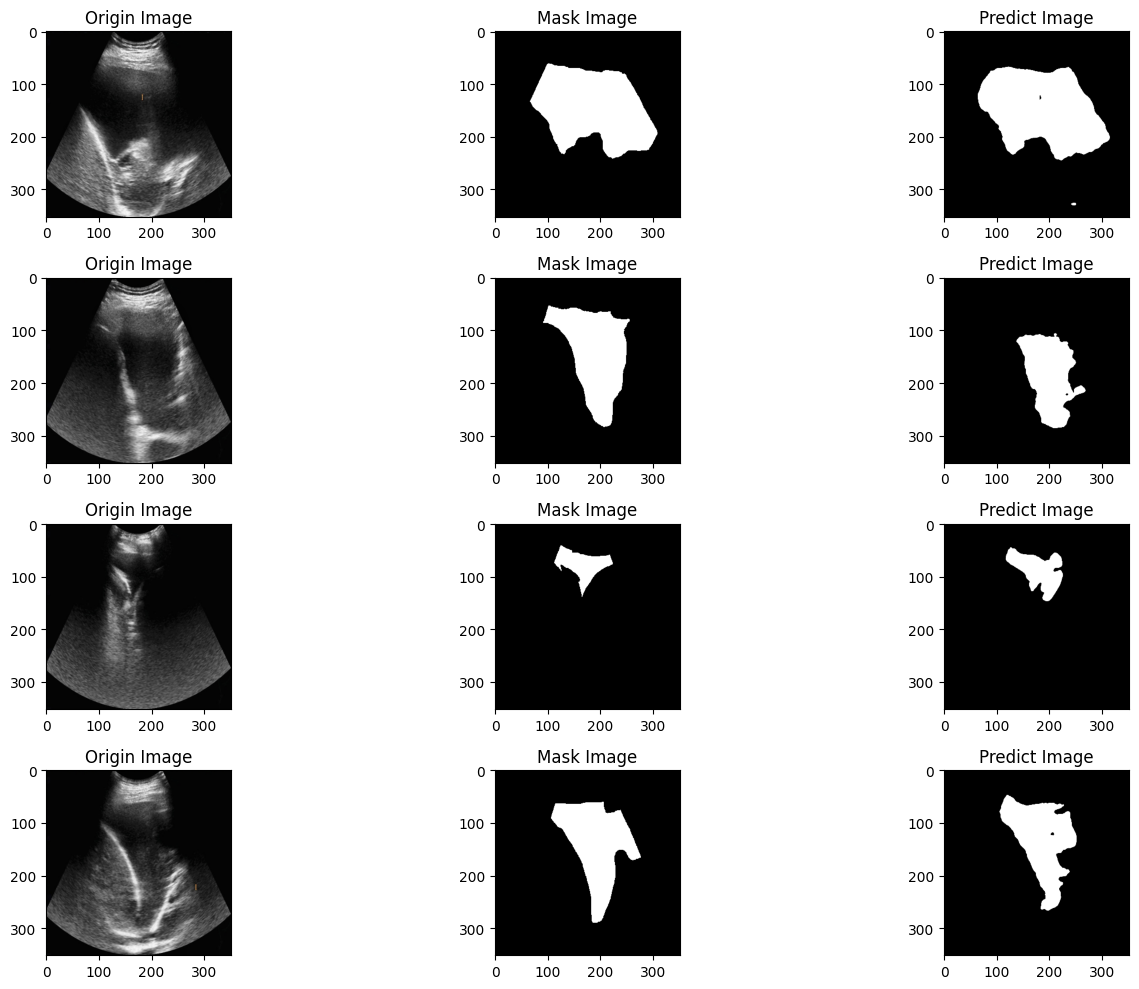

Predictions done
Dice finished
Miou finished
Precision finished
Recall finished
Accuracy finished
results_BCDUnet_17_kvasir.txt
File done


In [21]:
# Computing the metrics and saving the results

print("Loading the model")

model = tf.keras.models.load_model(model_path, custom_objects={'dice_metric_loss':dice_metric_loss})

prediction_train = model.predict(x_train, batch_size=4)
prediction_valid = model.predict(x_valid, batch_size=4)
prediction_test = model.predict(x_test, batch_size=4)

fig, axs = plt.subplots(4, 3, figsize=(15, 10))

for i in range(len(prediction_test)):
    origin = x_test[i]
    origin = origin.squeeze()
    axs[i, 0].imshow(origin, cmap='gray') 
    axs[i, 0].set_title('Origin Image')

    mask = y_test[i]
    mask = mask.squeeze()
    axs[i, 1].imshow(mask, cmap='gray') 
    axs[i, 1].set_title('Mask Image')
    
    pred = prediction_test[i]
    pred = pred.squeeze()
    axs[i, 2].imshow(pred, cmap='gray')
    axs[i, 2].set_title('Predict Image')

plt.tight_layout()
plt.show()

print("Predictions done")

dice_train = f1_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
dice_test = f1_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
dice_valid = f1_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Dice finished")


miou_train = jaccard_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                           np.ndarray.flatten(prediction_train > 0.5))
miou_test = jaccard_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                          np.ndarray.flatten(prediction_test > 0.5))
miou_valid = jaccard_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                           np.ndarray.flatten(prediction_valid > 0.5))

print("Miou finished")


precision_train = precision_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                  np.ndarray.flatten(prediction_train > 0.5))
precision_test = precision_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                                 np.ndarray.flatten(prediction_test > 0.5))
precision_valid = precision_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                  np.ndarray.flatten(prediction_valid > 0.5))

print("Precision finished")


recall_train = recall_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                            np.ndarray.flatten(prediction_train > 0.5))
recall_test = recall_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                           np.ndarray.flatten(prediction_test > 0.5))
recall_valid = recall_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                            np.ndarray.flatten(prediction_valid > 0.5))

print("Recall finished")


accuracy_train = accuracy_score(np.ndarray.flatten(np.array(y_train, dtype=bool)),
                                np.ndarray.flatten(prediction_train > 0.5))
accuracy_test = accuracy_score(np.ndarray.flatten(np.array(y_test, dtype=bool)),
                               np.ndarray.flatten(prediction_test > 0.5))
accuracy_valid = accuracy_score(np.ndarray.flatten(np.array(y_valid, dtype=bool)),
                                np.ndarray.flatten(prediction_valid > 0.5))


print("Accuracy finished")


final_file = 'results_' + model_type + '_' + str(filters) + '_' + dataset_type + '.txt'
print(final_file)

with open(final_file, 'a') as f:
    f.write(dataset_type + '\n\n')
    f.write('dice_train: ' + str(dice_train) + ' dice_valid: ' + str(dice_valid) + ' dice_test: ' + str(dice_test) + '\n\n')
    f.write('miou_train: ' + str(miou_train) + ' miou_valid: ' + str(miou_valid) + ' miou_test: ' + str(miou_test) + '\n\n')
    f.write('precision_train: ' + str(precision_train) + ' precision_valid: ' + str(precision_valid) + ' precision_test: ' + str(precision_test) + '\n\n')
    f.write('recall_train: ' + str(recall_train) + ' recall_valid: ' + str(recall_valid) + ' recall_test: ' + str(recall_test) + '\n\n')
    f.write('accuracy_train: ' + str(accuracy_train) + ' accuracy_valid: ' + str(accuracy_valid) + ' accuracy_test: ' + str(accuracy_test) + '\n\n\n\n')

print('File done')